
Neste colab iremos treinar um modelo para fazer análise de sentimento usando o dataset IMDB.

# Auto Atenção (Aparentemente tem vazamento, a validação está indo para 100% de acurácia)

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#Minhas importações
import numpy as np
import nltk
from collections import defaultdict
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import json
from sklearn.metrics import accuracy_score
import statistics 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from numpy import genfromtxt
import scipy
import time

cuda


# Preparando Dados do dataset IMDB

Primeiro, fazemos download do dataset:

In [3]:
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

--2020-04-14 21:53:33--  http://files.fast.ai/data/examples/imdb_sample.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571827 (558K) [application/x-gtar-compressed]
Saving to: ‘imdb_sample.tgz’

imdb_sample.tgz     100%[===================>] 558.42K  1.85MB/s    in 0.3s    

2020-04-14 21:53:34 (1.85 MB/s) - ‘imdb_sample.tgz’ saved [571827/571827]



Carregamos o dataset .csv usando o pandas:

In [4]:
df = pd.read_csv('imdb_sample/texts.csv')
df.shape
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Iremos agora dividir o dataset em conjuntos de treino e desenvolmento:

In [5]:
treino = df[df['is_valid'] == False]
valid = df[df['is_valid'] == True]

print('treino.shape:', treino.shape)
print('valid.shape:', valid.shape)

treino.shape: (800, 3)
valid.shape: (200, 3)


E iremos dividir estes dois conjuntos em entrada (X) e saída desejada (Y, ground-truth) do modelo:


In [6]:
X_treino = treino['text']
Y_treino = treino['label']
X_valid = valid['text']
Y_valid = valid['label']

print('X_treino.head():', X_treino.head())
print('Y_treino.head():', Y_treino.head())

X_treino.head(): 0    Un-bleeping-believable! Meg Ryan doesn't even ...
1    This is a extremely well-made film. The acting...
2    Every once in a long while a movie will come a...
3    Name just says it all. I watched this movie wi...
4    This movie succeeds at being one of the most u...
Name: text, dtype: object
Y_treino.head(): 0    negative
1    positive
2    negative
3    positive
4    negative
Name: label, dtype: object


Ainda falta converter as strings "positive" e "negative" do ground-truth para valores booleanos:

In [7]:
mapeamento = {'positive': True, 'negative': False}
Y_treino_bool = Y_treino.map(mapeamento)
Y_valid_bool = Y_valid.map(mapeamento)
print(Y_treino_bool.head())

0    False
1     True
2    False
3     True
4    False
Name: label, dtype: bool


# Processamento do texto (Nesta etapa processo o texto do X_train para que o modelo seja treinado apenas com as palavras mais relevantes)


O pré processamento só será feito no dataset de treino, para fazer sentido


In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
X_treino_lista = list(X_treino.copy())

In [0]:

def tokenize_sem_pontuacao(lista_texto):#para usar em treino
  lista_tokens = []
  for texto in lista_texto:
    for char in [',','.',';',':','!','?','/','\\','*','"','br','<','>','\n','\t']:
      texto = texto.replace(char,' ')
    lista_tokens.append(texto.split())

  return lista_tokens


def tokenize_com_pontuacao(lista_texto):#para usar em validacao no Glove
  # splitted = [texto.split() for texto in lista_texto]
  splitted = []
  for texto in lista_texto:
    texto_split = texto.split()
    splitted.append(texto_split)
  return splitted
  

def top_tokens_stop_words(lista_tokens,porcentagem_melhores):
  vocab = defaultdict(int)
  for sample in lista_tokens:
      for tok in sample:
          vocab[tok] += 1
  all_tokens = sorted(vocab.items(), key=lambda i: i[1], reverse=True)
  best_tokens = all_tokens[:int(len(all_tokens)*porcentagem_melhores)]
  best_tokens = [best_token[0] for best_token in best_tokens]

  return best_tokens

def stop_words_nltk():
  stopwords = nltk.corpus.stopwords.words('english')
  return stopwords

def remove_tokens_especificos(matriz_tokens,tokens_especificos):
  lista_tokens_filtrados = []
  for sample in matriz_tokens:
    lista_tokens_filtrados.append([x for x in sample if x not in tokens_especificos])
    

  return lista_tokens_filtrados

  

In [11]:
lista_tokens = tokenize_sem_pontuacao(X_treino_lista)
top_tokens = top_tokens_stop_words(lista_tokens,0.01)# o 1% que mais aparece
stopwords_nltk = stop_words_nltk()
stopwords = top_tokens + list(set(stopwords_nltk) - set(top_tokens))
X_treino_filtrado = remove_tokens_especificos(lista_tokens,stopwords) 
print(stopwords[:20])
print(X_treino_filtrado[:5])


['the', 'and', 'a', 'of', 'to', 'is', 'in', 'that', 'I', 'it', 'this', 'was', 'The', 'for', 'movie', 'as', 'with', 'film', 'but', 'on']
[['Un-bleeping-believable', 'Meg', 'Ryan', 'usual', 'pert', 'lovable', 'self', 'normally', 'forgive', 'shallow', 'ticky', 'schtick', 'Hard', 'believe', 'producer', 'dog', 'Plus', 'Kevin', 'Kline', 'kind', 'suicide', 'trip', 'career', 'Whoosh', 'Banzai', 'Finally', 'directed', 'guy', 'Big', 'Chill', 'Must', 'replay', 'Jonestown', 'hollywood', 'style', 'Wooofff'], ['extremely', 'well-made', 'script', 'camera-work', 'first-rate', 'music', 'mostly', 'early', 'relatively', 'cheery', 'superstars', 'several', 'faces', 'familiar', 'entire', 'excellent', 'job', 'script', 'hard', 'situation', 'presented', 'fashionable', 'blame', 'British', 'setting', 'Hindus', 'Muslims', 'cruelly', 'separating', 'countries', 'merit', 'view', 'true', 'forced', 'Hindus', 'Muslims', 'region', 'mistreat', 'partition', 'likely', 'British', 'simply', 'saw', 'tensions', 'religions', 'c

# Embeddings BAG pré treinados GLOVE

In [12]:
import gensim.downloader as api

glove = api.load("glove-wiki-gigaword-300")


[==================================================] 100.0% 376.1/376.1MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [13]:
print(glove.vectors.shape)

(400000, 300)


In [14]:
glove_dim = 300
glove_words = glove.index2word
glove_vocab = {word: index for index, word in enumerate(glove.index2word)}
glove_vectors = torch.Tensor(glove.vectors)
print(list(glove_vocab.items())[:20])

[('the', 0), (',', 1), ('.', 2), ('of', 3), ('to', 4), ('and', 5), ('in', 6), ('a', 7), ('"', 8), ("'s", 9), ('for', 10), ('-', 11), ('that', 12), ('on', 13), ('is', 14), ('was', 15), ('said', 16), ('with', 17), ('he', 18), ('as', 19)]


In [15]:
# solução inspirada pelo Paulo Finardi
# Percebi que isso precisava ser feito porque quando se coloca emb(seqs) não tem como tratar o 0 antes que ele vire uma glove_vector do anterior, caso 'the'
glove_stoi = glove_vocab
glove_vocab = glove_stoi.copy()

pad_vector = (torch.zeros_like(glove_vectors[0])).view(-1,300) # pra ficar [1,300] no lugar de [300]
new_glove_vectors = torch.cat([pad_vector, glove_vectors], dim=0) # torch.Size([400001, 300])
new_glove_vocab = {word:(index+1) for word, index in glove_vocab.items()}
new_glove_vocab['<pad>'] = 0
print('Primeiras 20 palavras e seus índices:',list(new_glove_vocab.items())[-1], list(new_glove_vocab.items())[:20])



Primeiras 20 palavras e seus índices: ('<pad>', 0) [('the', 1), (',', 2), ('.', 3), ('of', 4), ('to', 5), ('and', 6), ('in', 7), ('a', 8), ('"', 9), ("'s", 10), ('for', 11), ('-', 12), ('that', 13), ('on', 14), ('is', 15), ('was', 16), ('said', 17), ('with', 18), ('he', 19), ('as', 20)]


In [16]:
def constroi_matriz_glove(X,etapa,stopwords=stopwords):
  matriz_glove = []
  matriz_words_filtradas = []
  for token_line in X:
    if etapa == 'treino':
      token_phrase = [new_glove_vocab[word] for word in token_line if (word in new_glove_vocab and word not in stopwords)]
      words_filtrados =  [word for word in token_line if (word in new_glove_vocab and word not in stopwords)]
    elif etapa == 'valid':
      token_phrase = [new_glove_vocab[word] for word in token_line if (word in new_glove_vocab)]
      words_filtrados = [word for word in token_line if (word in new_glove_vocab)]
    matriz_words_filtradas.append(words_filtrados)
    matriz_glove.append(token_phrase)
  
  return matriz_glove , matriz_words_filtradas

#tokenizacao
# X_treino_glove = tokenize_sem_pontuacao(list(X_treino.copy()))
X_treino_glove = X_treino_filtrado.copy()
X_valid_glove = tokenize_com_pontuacao(list(X_valid.copy()))

#listas de listas construidas
X_treino_glove_ids,X_treino_glove_words  = constroi_matriz_glove(X_treino_glove.copy(),'treino')
X_valid_glove_ids,X_valid_glove_words = constroi_matriz_glove(X_valid_glove.copy(),'valid')

#passar Y pra lista 
Y_treino_final = list(Y_treino_bool.copy())
Y_valid_final = list(Y_valid_bool.copy())

print(X_treino_glove_ids[0])
print(X_treino_glove_words[0])



[3519, 86322, 31907, 1497, 3521, 13340, 8967, 170724, 109385, 734, 1939, 2927, 922, 1524, 1306, 433, 1682, 1857, 11963, 2291, 1136]
['usual', 'pert', 'lovable', 'self', 'normally', 'forgive', 'shallow', 'ticky', 'schtick', 'believe', 'producer', 'dog', 'kind', 'suicide', 'trip', 'career', 'directed', 'guy', 'replay', 'hollywood', 'style']


# Trucamento + Padding + Alteração dos parâmetros do GLOVE

Primeiramente é preciso inserir o ID do Padding dentro do glove_vectors(vou colocar 0 id de zero para o Pad e o resto começa a partir de 1) 

O padding será feito no tamanho máximo dentro os disponíveis em treino. Se em validação tiver um tamanho maior é truncado para este valor

In [0]:
#Encontrando lista de tamanho máximo no treino
# lista_len_max_treino = max(X_treino_glove_ids,key=len)
# len_max_treino = len(lista_len_max_treino)
# print(len_max_treino, lista_len_max_treino)
len_max_treino  =150

In [18]:
#Padding no max entre os valores de treino

# truncado=np.array([xi[:15] for xi in X_treino_glove_ids]) #Se eu quiser apenas truncar faço assim
# print(trucar)

# X_treino_id_padded=np.array([xi+[0]*(len_max_treino-len(xi)) for xi in X_treino_glove_ids])
X_treino_id_padded = np.array([xi+[0]*(len_max_treino-len(xi)) if (len(xi) < len_max_treino) else xi[:len_max_treino] for xi in X_treino_glove_ids ])
print('X treino Padded\n')
print(X_treino_id_padded)
X_valid_id_padded = np.array([xi+[0]*(len_max_treino-len(xi)) if (len(xi) < len_max_treino) else xi[:len_max_treino] for xi in X_valid_glove_ids ])
print('\n X valid Padded + truncated\n')
print(X_valid_id_padded)

X treino Padded

[[  3519  86322  31907 ...      0      0      0]
 [  2709 128102   5231 ...      0      0      0]
 [   174    327    386 ...      0      0      0]
 ...
 [  1175     17   4346 ...      0      0      0]
 [ 10231  10231   8561 ...      0      0      0]
 [   457   2433   1940 ...      0      0      0]]

 X valid Padded + truncated

[[  192  5467  2842 ...     0     0     0]
 [  823    38  1006 ...     0     0     0]
 [    7   193     8 ...     0     0     0]
 ...
 [   16   354    18 ...   254   164    15]
 [    8   320    18 ...  1771     1  1006]
 [    6 26097  5608 ...  1690    78    15]]


In [0]:
Y_treino = np.array(Y_treino_final)
Y_valid = np.array(Y_valid_final)


In [0]:
np.savetxt("x_train.csv", X_treino_id_padded, delimiter=",")
np.savetxt("y_train.csv", Y_treino, delimiter=",")
np.savetxt("x_valid.csv", X_valid_id_padded, delimiter=",")
np.savetxt("y_valid.csv", Y_valid, delimiter=",")

# Classe IMDB Dataset (Transformação dos dados em tensores pytorch)



In [0]:
class ImdbDataset(Dataset):
  def __init__(self, csv_path_label,csv_path_target):
    super(ImdbDataset, self).__init__()
    self.x = genfromtxt(csv_path_label, delimiter=',')
    self.target = genfromtxt(csv_path_target, delimiter=',')

    self.target = torch.from_numpy(self.target).type(torch.LongTensor)
    self.x      = torch.from_numpy(self.x).type(torch.LongTensor)

    one_tensor = torch.ones_like(self.x)
    self.mask = torch.where(self.x==0,self.x,one_tensor)


  def __len__(self):
    return self.x.shape[0]
  
  def __getitem__(self, index):
    return self.x[index],self.mask[index],self.target[index]

In [22]:
# testing class
torch_ds_train = ImdbDataset('x_train.csv','y_train.csv')
x0, mask0,y0 = torch_ds_train[0]
print(x0, mask0, y0)

torch_ds_test = ImdbDataset('x_valid.csv','y_valid.csv')
x0,mask0,y0 = torch_ds_test[0]
print(x0,mask0, y0)

tensor([  3519,  86322,  31907,   1497,   3521,  13340,   8967, 170724, 109385,
           734,   1939,   2927,    922,   1524,   1306,    433,   1682,   1857,
         11963,   2291,   1136,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [23]:
# testing DataLoader
torch_ds_train = ImdbDataset('x_train.csv','y_train.csv')
train_loader = DataLoader(torch_ds_train, 20, shuffle=False)
x_train, mask_train , y_train = next(iter(train_loader)) # 1 batch

torch_ds_test = ImdbDataset('x_valid.csv','y_valid.csv')
test_loader = DataLoader(torch_ds_test, 20, shuffle=True)
x_test, mask_test, y_test = next(iter(test_loader))  # 1 batch

print('Treino')
print(x_train)
print(y_train)
print(f'input shape: {x_train.shape}') 
print(f'mask_train shape: {mask_train.shape}') 
print(f'label shape: {y_train.shape}')

print('\nTeste')
print(x_test)
print(y_test)
print(f'input shape: {x_test.shape}')
print(f'mask_test shape: {mask_test.shape}')
print(f'label shape: {y_test.shape}')

Treino
tensor([[  3519,  86322,  31907,  ...,      0,      0,      0],
        [  2709, 128102,   5231,  ...,      0,      0,      0],
        [   174,    327,    386,  ...,      0,      0,      0],
        ...,
        [   691,   5573,    478,  ...,      0,      0,      0],
        [  1447,  15277,   9639,  ...,      0,      0,      0],
        [   631,   8232,   2200,  ...,      0,      0,      0]])
tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1])
input shape: torch.Size([20, 150])
mask_train shape: torch.Size([20, 150])
label shape: torch.Size([20])

Teste
tensor([[  190,   347,    13,  ...,     0,     0,     0],
        [30213,     7,     1,  ...,     0,     0,     0],
        [   65,    52,  2996,  ...,    64,    33,    92],
        ...,
        [    5,    15,    13,  ...,   182,   152,    18],
        [80797,  1063,     4,  ...,     6,    68,    15],
        [  270,     1,   883,  ...,     1,   979,  2051]])
tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,

# Função self attention loop (Irei colocar dentro dos modelos)


In [0]:
# Baseado na solução do professor com a máscara ja incluida pelos ifs
class AttentionLoop(torch.nn.Module):
  def forward(self,seqs):

    # L = comprimento da sequência
    # D = dimensão do embeddings
    # N = batch_size = seqs.size(0)
    # L x D -> Tem que ser o tamanho do vetor E 
    # N x L x D -> Tem que ser o tamanho do vetor lista_attention_embeddings
    
    lista_attention_embeddings = []
    # para cada sequência de ids
    for seq in seqs:
      E = [] # new attention embeddings.
      for q in seq:
        if q==0:
          probs = torch.zeros(len(seq)) #significa que no fim C(W)=E(W)=0
        else:
          scores = [] 
          for k in seq:
            #Produto Escalar: Mede similaridade entre vetor corrente glove_vectors[q] e outros vetores
            if k ==0:
              score = torch.tensor(-1e10)
            else:
              score = torch.matmul(new_glove_vectors[q],new_glove_vectors[k].T) # O que o professor diz ser o C(q) é colocar os trazer o vetor de gloves a partir dos word_ids
            scores.append(score)
          score_unique_tensor = torch.stack(scores)
          probs = F.softmax(score_unique_tensor,dim=0)
        #Soma ponderada dos embeddings
        new_embedding = 0
        for v, p in zip(seq, probs):
          new_embedding += new_glove_vectors[v] * p
        E.append(new_embedding)
      E = torch.stack(E)# Transforma uma lista de tensores em um tensor grandão de tensores
      lista_attention_embeddings.append(E) # Lista de tensores  (L x D) com N elementos
    tensor_embedings =  torch.stack(lista_attention_embeddings) # tensor (N x L x D)
    return tensor_embedings

In [25]:
att  = AttentionLoop()
tensor_embedings = att(x_train)
tensor_embedings.shape

torch.Size([20, 150, 300])

# Função self attention matricial (Irei colocar dentro dos modelos)

In [0]:
class AttentionMatrix(torch.nn.Module):
  def forward(self,K,Q,V):
    scores = torch.matmul(Q,K.transpose(-1,-2)) # N,L,L
    mask = torch.ones_like(scores)*(-1e10)
    score_com_mascara = torch.where(scores!=0,scores,mask)
    probs = F.softmax(score_com_mascara,dim=2)
    E = torch.matmul(probs, V)
    return E

In [0]:
%%capture
emb = torch.nn.Embedding.from_pretrained(new_glove_vectors)
emb.requires_grad = False #400000, 300
att  = AttentionMatrix()
tensor_embedings = att(emb(x_train),emb(x_train),emb(x_train))
tensor_embedings.shape

# Modelo com Self Attention(dois tipos)

In [0]:
class MPLAttention(torch.nn.Module):
    def __init__(self,hidden_dim ,mode):
        super(MPLAttention, self).__init__()

        self.mode = mode          
  
        self.weight = new_glove_vectors #pesos fixos pré treinados
        self.embedding_dim = glove_dim 
        self.emb = torch.nn.Embedding.from_pretrained(self.weight, freeze=True)#400000, 300
        self.emb.requires_grad = False 

        self.self_attention =  AttentionMatrix() if self.mode == 'matrix' else AttentionLoop() 

        self.layer1 = torch.nn.Linear(self.embedding_dim,hidden_dim)
        self.layer2 = torch.nn.Linear(hidden_dim,2)

        layers= [self.layer1,self.layer2]

        self.net = torch.nn.Sequential(*layers)  


    def forward(self, seqs, mask):
      X_emb = self.emb(seqs)
      if self.mode == 'matrix':
        E = self.self_attention(X_emb.clone(),X_emb.clone(),X_emb.clone())
      else:
        E = self.self_attention(seqs)# não precisa embedar por causa dos meus ifs

      #Media dos embeddings - Fabio Beranizo me explicou como fazer
      E_sum = torch.sum(E, dim=1)
      mask = torch.sum(mask, dim=1)
      E_sum_transposto = torch.t(E_sum)
      E_mean = torch.div(E_sum_transposto, mask)

      hidden = torch.relu(self.layer1(torch.t(E_mean)))
      logits = self.layer2(hidden)
      return logits

Sanity Check

In [0]:
%%capture
model = MPLAttention(100,'matrix')
Y = model(x_train,mask_train)

In [30]:
print(Y)

tensor([[0.0841, 0.0839],
        [0.0956, 0.0787],
        [0.1234, 0.0565],
        [0.0917, 0.0942],
        [0.1340, 0.0517],
        [0.1431, 0.0309],
        [0.0992, 0.0812],
        [0.0819, 0.0615],
        [0.1311, 0.0815],
        [0.1294, 0.0455],
        [0.0789, 0.0624],
        [0.1187, 0.0716],
        [0.0550, 0.0761],
        [0.1131, 0.0758],
        [0.1147, 0.0858],
        [0.0839, 0.0968],
        [0.0814, 0.0715],
        [0.1327, 0.0557],
        [0.1999, 0.0923],
        [0.1826, 0.0582]], grad_fn=<AddmmBackward>)


# Funções de Treino e Teste + funções para salvar testes

In [0]:
def train(model, train_loader, criterion, optimizer):
  model.train() #modo de treino
  loss_batch_vector = []
  correct = 0 
  total = 0
  for inputs, mask, target in train_loader:
    inputs, mask, target = inputs.to(device), mask.to(device),  target.to(device)

    optimizer.zero_grad()
    y_logits = model(inputs,mask)
    #loss
    loss = criterion(y_logits, target)#criterion is the loss function
    loss_batch_vector.append(loss.item())
    loss.backward()
    optimizer.step()

  loss_mean = sum(loss_batch_vector)/len(loss_batch_vector)

    
  return loss_mean
# utilizei a técnica de recuperar o score do Paulo Finardi
def test(model, test_loader, criterion, optimizer):
  model.eval()#modo de avaliação
  correct = 0 
  total = 0
  loss_batch_vector = []
  with torch.no_grad():
    for inputs, mask, target in test_loader:
      inputs, mask, target = inputs.to(device), mask.to(device),  target.to(device)
      y_logits = model(inputs,mask)
      #acc
      _, predicted = torch.max(y_logits.data, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()
  acc_mean = (100 * correct / total)
  return acc_mean

In [0]:
def save_pickle(obj, filename):
  with open(filename, 'wb') as handle:
      pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def save_json(obj, filename):
  with open(filename, 'a') as outfile:
    json.dump(obj, outfile)

def open_pickle(filename):
  with open(filename, 'rb') as handle:
      return pickle.load(handle)

# Função de Avaliação

In [0]:
def evaluate(model,torch_ds_train,torch_ds_test,LR,BS,N_EPOCHS):
  #Parâmetros Fixos

  criterion = torch.nn.CrossEntropyLoss().to(device)

  trials = {}
  results = {}
  train_loss_list = []
  test_acc_list = []
  id_best_iteration = 0
  best_acc = 0
  
  optimizer = torch.optim.SGD(model.parameters(), lr=LR)
  for EP in range(N_EPOCHS):

    train_loader = DataLoader(torch_ds_train, BS, shuffle=True)
    test_loader = DataLoader(torch_ds_test, BS, shuffle=False)

    train_loss =  train(model, train_loader, criterion, optimizer)
    test_acc =  test(model, test_loader, criterion, optimizer)

    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)

    best_acc = best_acc if (best_acc>test_acc) else test_acc

  trials = {
            'lr': LR,
            'batch_size':BS,
            'num_epoch':N_EPOCHS,
        }

  results = {
            'train_loss': train_loss_list,
            'test_acc': test_acc_list,
            'best_acc':best_acc
        }

  save_pickle(trials, 'trials.pickle')
  save_json(trials, 'trials.json')
  save_pickle(results, 'results.pickle')
  save_json(results, 'results.json')


  return train_loss_list, test_acc_list
      

# Função de Visualização

In [0]:
def visualization(N_EPOCHS,train_loss_list,test_acc_list):

  x = range(N_EPOCHS)

  # Loss plot
  plt.subplot(1, 2, 1)
  plt.xlabel("Epoch")
  plt.ylabel("Train Loss")
  plt.plot(x, train_loss_list, '-')
  plt.legend()

  # Accuracy plot
  plt.subplot(1, 2, 2)
  plt.xlabel("Epoch")
  plt.ylabel("Test Accuracy")
  plt.plot(x, test_acc_list, '-')
  plt.legend()

  plt.tight_layout()
  plt.show()



# Experimento Matricial

In [0]:
torch_ds_train = ImdbDataset('x_train.csv','y_train.csv')
torch_ds_test = ImdbDataset('x_valid.csv','y_valid.csv')

In [0]:
%%capture
model = MPLAttention(hidden_dim=128,mode='matrix').to(device)
model.to(device)
# n_nodes = sum([torch.tensor(x.size()).prod() for x in model.parameters()])
#Parametros que variam
LR =0.005
BS=30
N_EPOCHS = 400
train_loss_list, test_acc_list = evaluate(model,torch_ds_train,torch_ds_test,LR,BS,N_EPOCHS)

In [37]:
model = MPLAttention(hidden_dim=64,mode='matrix').to(device)
model.to(device)
n_nodes = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(n_nodes)

19394


No handles with labels found to put in legend.
No handles with labels found to put in legend.


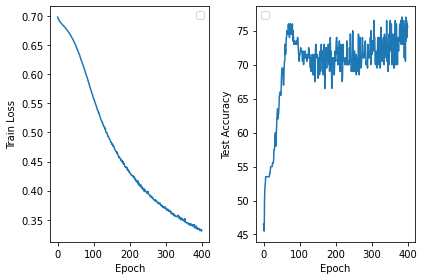

In [38]:
visualization(N_EPOCHS,train_loss_list,test_acc_list)

# Experimento Loop


In [0]:
%%capture
model = MPLAttention(hidden_dim=64,mode='loop').to(device)
model.to(device)
# n_nodes = sum([torch.tensor(x.size()).prod() for x in model.parameters()])
#Parametros que variam
LR =0.009
BS=20
N_EPOCHS = 200
train_loss_list, test_acc_list = evaluate(model,torch_ds_train,torch_ds_test,LR,BS,N_EPOCHS)

RuntimeError: ignored

ValueError: ignored

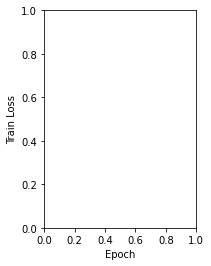

In [0]:
visualization(N_EPOCHS,train_loss_list,test_acc_list)

#Avaliação do tempo

Tempo para o Calculo Matricial 1 época e batch de 20

In [0]:
n_words = 0
for batch in x_train:
  for palavra in batch:
    if palavra != torch.tensor(0):
      n_words+=1

print(n_words)

In [0]:
%%capture
start_time = time.time()
emb = torch.nn.Embedding.from_pretrained(new_glove_vectors, freeze=True)
emb.requires_grad = False #400000, 300
att  = AttentionMatrix()
tensor_embedings = att(emb(x_train),emb(x_train),emb(x_train))
end_time = (time.time() - start_time)


In [0]:
print("--- %s seconds ---" % end_time)

Tempo para o Calculo Loop 1 época e batch de 20

In [0]:
%%capture
start_time = time.time()
att  = AttentionLoop()
tensor_embedings = att(x_train)
tensor_embedings.shape
end_time = (time.time() - start_time)



In [0]:
print("--- %s seconds ---" % end_time)